In [1]:
!pip install torch torchvision torchaudio --quiet
!pip install rasterio --quiet
!pip install numpy pandas scikit-learn matplotlib tqdm --quiet


In [2]:
import os
import glob
import torch
import rasterio
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [3]:
data_dir = r"C:\Users\ask\Downloads\EuroSAT_MS\EuroSAT_MS"
print("Folders:", os.listdir(data_dir))


Folders: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [4]:
habitat_score = {
    "Forest": 95,
    "Pasture": 80,
    "HerbaceousVegetation": 75,
    "SeaLake": 60,
    "River": 65,
    "PermanentCrop": 70,
    "AnnualCrop": 65,
    "Residential": 30,
    "Industrial": 20,
    "Highway": 10
}


In [5]:
class EuroSATDataset(Dataset):
    def __init__(self, root_dir, mapping, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.mapping = mapping
        self.samples = []

        folders = os.listdir(root_dir)
        for folder in folders:
            folder_path = os.path.join(root_dir, folder)
            if not os.path.isdir(folder_path):
                continue
            image_paths = glob.glob(folder_path + "/*.tif")
            for img in image_paths:
                self.samples.append((img, mapping[folder]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        with rasterio.open(img_path) as src:
            img = src.read()        # shape = (13, H, W)

        img = img.astype(np.float32)
        img = img / img.max()      # normalize 0–1

        if self.transform:
            img = torch.tensor(img)

        return img, torch.tensor([label], dtype=torch.float32)


In [6]:
dataset = EuroSATDataset(data_dir, habitat_score)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

len(train_loader), len(test_loader)


(1350, 338)

In [7]:
class ResNetRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(weights=None)

        # Change first conv input channels from 3 → 13
        self.model.conv1 = nn.Conv2d(13, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Output 1 regression value (habitat score)
        self.model.fc = nn.Linear(512, 1)

    def forward(self, x):
        return self.model(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNetRegressor().to(device)


In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)


In [9]:
epochs = 10
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")


100%|██████████████████████████████████████████████████████████████████████████████| 1350/1350 [18:02<00:00,  1.25it/s]


Epoch 1/10 - Loss: 435.8356


100%|██████████████████████████████████████████████████████████████████████████████| 1350/1350 [12:55<00:00,  1.74it/s]


Epoch 2/10 - Loss: 117.8091


100%|██████████████████████████████████████████████████████████████████████████████| 1350/1350 [13:26<00:00,  1.67it/s]


Epoch 3/10 - Loss: 86.8496


100%|██████████████████████████████████████████████████████████████████████████████| 1350/1350 [13:41<00:00,  1.64it/s]


Epoch 4/10 - Loss: 71.3461


100%|██████████████████████████████████████████████████████████████████████████████| 1350/1350 [13:36<00:00,  1.65it/s]


Epoch 5/10 - Loss: 64.8048


100%|██████████████████████████████████████████████████████████████████████████████| 1350/1350 [13:16<00:00,  1.69it/s]


Epoch 6/10 - Loss: 53.7552


100%|██████████████████████████████████████████████████████████████████████████████| 1350/1350 [13:26<00:00,  1.67it/s]


Epoch 7/10 - Loss: 54.5018


100%|██████████████████████████████████████████████████████████████████████████████| 1350/1350 [13:11<00:00,  1.71it/s]


Epoch 8/10 - Loss: 46.7934


100%|██████████████████████████████████████████████████████████████████████████████| 1350/1350 [13:16<00:00,  1.70it/s]


Epoch 9/10 - Loss: 40.5138


100%|██████████████████████████████████████████████████████████████████████████████| 1350/1350 [14:58<00:00,  1.50it/s]

Epoch 10/10 - Loss: 38.3536


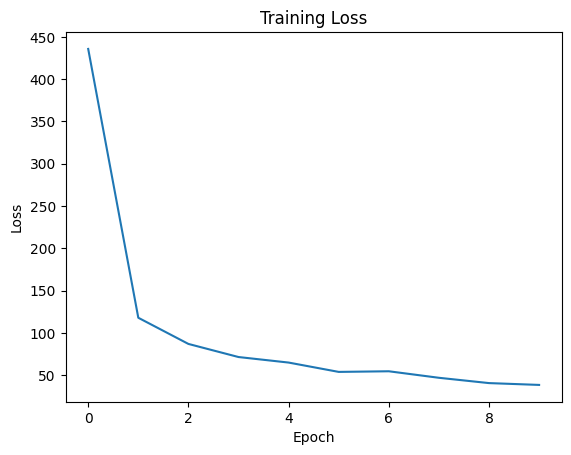

In [10]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [11]:
torch.save(model.state_dict(), "habitat_model.pth")
print("Model saved!")


Model saved!


In [12]:
def predict(img_path):
    model.eval()
    with rasterio.open(img_path) as src:
        img = src.read().astype(np.float32)
        img = img / img.max()

    img = torch.tensor(img).unsqueeze(0).to(device)
    with torch.no_grad():
        score = model(img).item()

    decline_risk = 100 - score

    return score, decline_risk

test_img = dataset.samples[0][0]
score, decline_risk = predict(test_img)

print("Habitat Health Score:", score)
print("Bird Population Decline Risk:", decline_risk)


Habitat Health Score: 65.23533630371094
Bird Population Decline Risk: 34.76466369628906


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())

y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("📌 TEST SET PERFORMANCE")
print("----------------------------")
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


📌 TEST SET PERFORMANCE
----------------------------
MAE : 4.7751970291137695
RMSE: 9.351684059621377
R²  : 0.8712281584739685


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Convert habitat score → decline category
def to_class(x):
    if x >= 70:     # good habitat → low decline
        return 0
    elif x >= 40:   # medium habitat → medium decline
        return 1
    else:           # poor habitat → high decline
        return 2

true_cls = np.array([to_class(v) for v in y_true])
pred_cls = np.array([to_class(v) for v in y_pred])

acc = accuracy_score(true_cls, pred_cls)
prec = precision_score(true_cls, pred_cls, average='weighted')
rec = recall_score(true_cls, pred_cls, average='weighted')
f1 = f1_score(true_cls, pred_cls, average='weighted')

print("📌 CLASSIFICATION METRICS (Low/Medium/High Decline)")
print("----------------------------------------------------")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)


📌 CLASSIFICATION METRICS (Low/Medium/High Decline)
----------------------------------------------------
Accuracy : 0.8381481481481482
Precision: 0.8832341408334051
Recall   : 0.8381481481481482
F1 Score : 0.8427573002867531


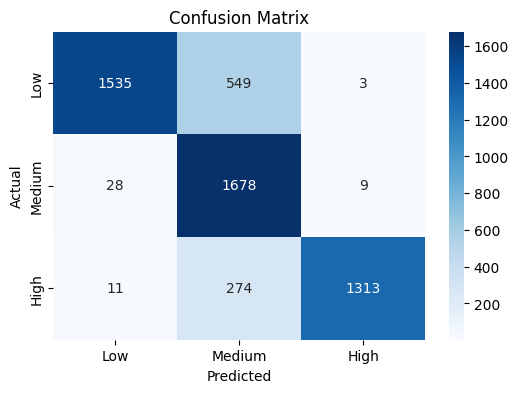

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_cls, pred_cls)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low","Medium","High"],
            yticklabels=["Low","Medium","High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


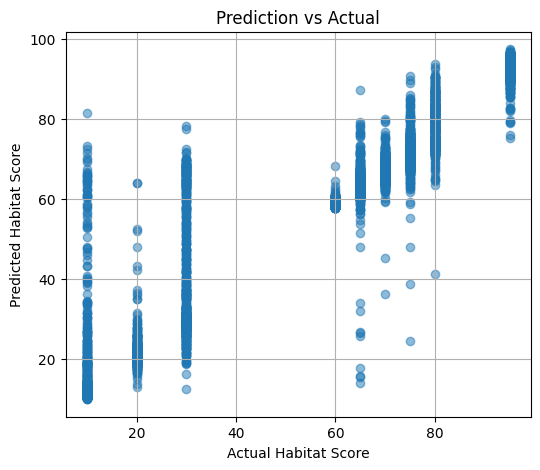

In [16]:
plt.figure(figsize=(6,5))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.xlabel("Actual Habitat Score")
plt.ylabel("Predicted Habitat Score")
plt.title("Prediction vs Actual")
plt.grid(True)
plt.show()


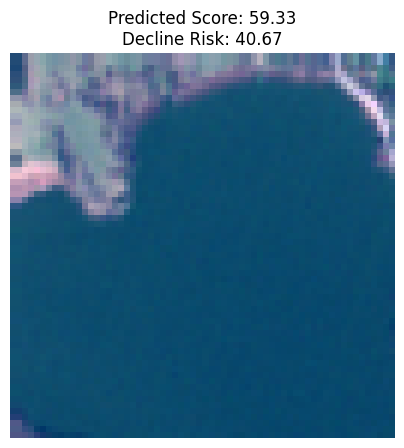

In [17]:
import random

def show_random_prediction():
    img_path, _ = random.choice(dataset.samples)
    score, decline_risk = predict(img_path)

    with rasterio.open(img_path) as src:
        img = src.read()

    # RGB: channels (4,3,2) → index (3,2,1)
    rgb = np.stack([img[3], img[2], img[1]], axis=-1)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

    plt.figure(figsize=(5,5))
    plt.imshow(rgb)
    plt.title(f"Predicted Score: {score:.2f}\nDecline Risk: {decline_risk:.2f}")
    plt.axis("off")
    plt.show()

show_random_prediction()


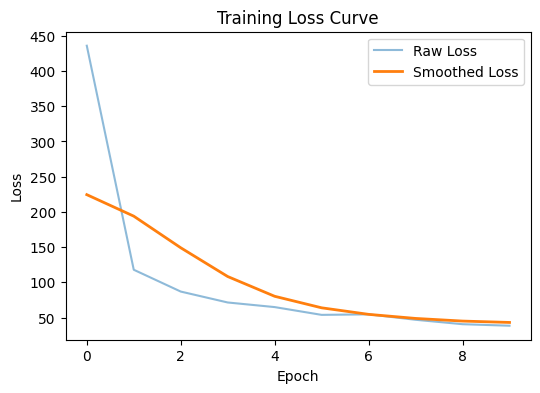

In [18]:
from scipy.ndimage import gaussian_filter1d

smooth_loss = gaussian_filter1d(train_losses, sigma=2)

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Raw Loss", alpha=0.5)
plt.plot(smooth_loss, label="Smoothed Loss", linewidth=2)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


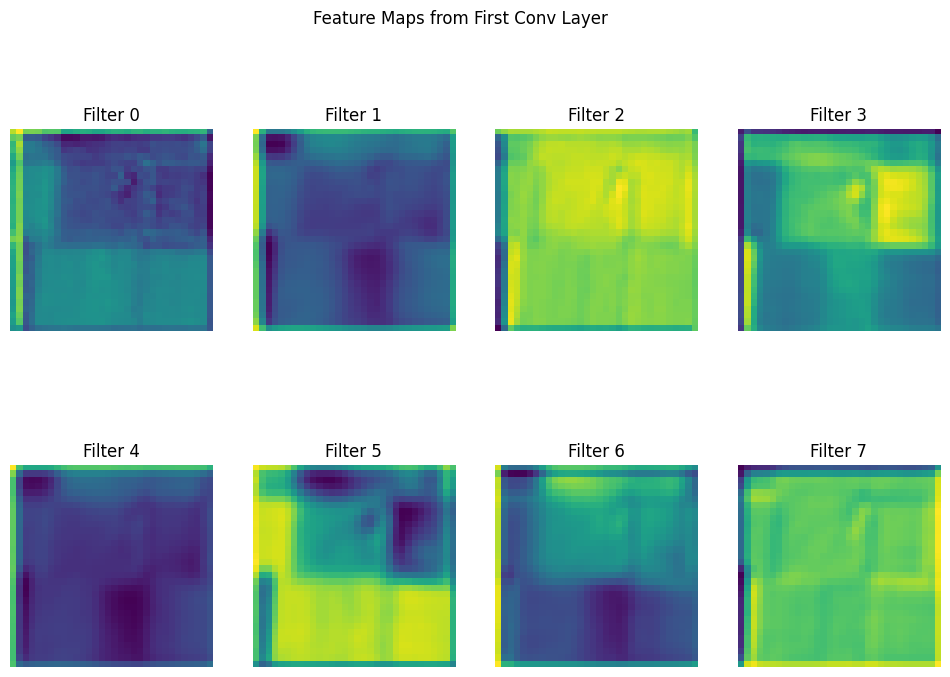

In [22]:
def visualize_feature_maps(img_path):
    with rasterio.open(img_path) as src:
        img = src.read().astype(np.float32)
        img = img / img.max()
        
    x = torch.tensor(img).unsqueeze(0).to(device)

    # Get first conv layer
    layer = model.model.conv1

    with torch.no_grad():
        fmap = layer(x).squeeze().cpu().numpy()

    plt.figure(figsize=(12,8))
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.imshow(fmap[i], cmap='viridis')
        plt.axis("off")
        plt.title(f"Filter {i}")

    plt.suptitle("Feature Maps from First Conv Layer")
    plt.show()

visualize_feature_maps(dataset.samples[0][0])


In [23]:
import numpy as np

def compute_indices(img):
    """
    img: numpy array with shape (13, H, W) in Sentinel-2 band order:
         [B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12]
    Returns: ndvi, ndwi, ndbi  (each H x W)
    """
    # Extract bands
    BLUE  = img[1].astype(np.float32)   # B02
    GREEN = img[2].astype(np.float32)   # B03
    RED   = img[3].astype(np.float32)   # B04
    NIR   = img[7].astype(np.float32)   # B08
    SWIR  = img[11].astype(np.float32)  # B11

    eps = 1e-6

    # Vegetation index
    ndvi = (NIR - RED) / (NIR + RED + eps)

    # Water index (green vs NIR variant)
    ndwi = (GREEN - NIR) / (GREEN + NIR + eps)

    # Built-up index
    ndbi = (SWIR - NIR) / (SWIR + NIR + eps)

    return ndvi, ndwi, ndbi


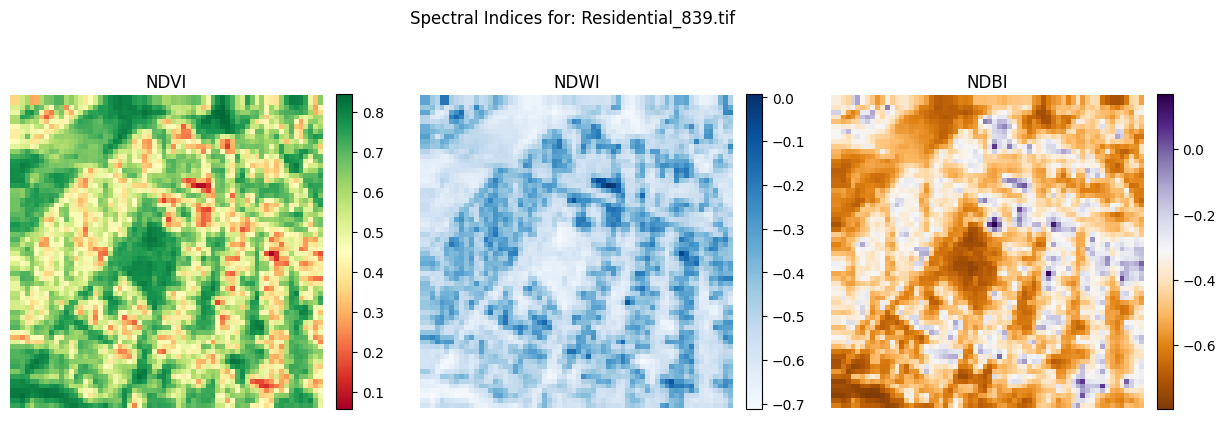

In [24]:
import random
import matplotlib.pyplot as plt
import rasterio

def visualize_indices_random():
    img_path, _ = random.choice(dataset.samples)

    with rasterio.open(img_path) as src:
        img = src.read()

    ndvi, ndwi, ndbi = compute_indices(img)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    im0 = axs[0].imshow(ndvi, cmap='RdYlGn')
    axs[0].set_title("NDVI")
    axs[0].axis('off')
    fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    im1 = axs[1].imshow(ndwi, cmap='Blues')
    axs[1].set_title("NDWI")
    axs[1].axis('off')
    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    im2 = axs[2].imshow(ndbi, cmap='PuOr')
    axs[2].set_title("NDBI")
    axs[2].axis('off')
    fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    plt.suptitle(f"Spectral Indices for: {os.path.basename(img_path)}")
    plt.show()

visualize_indices_random()


In [25]:
def get_land_cover_from_path(img_path):
    """
    Returns land-cover class name from the folder name.
    Example: .../EuroSAT_MS/Forest/img_1.tif -> 'Forest'
    """
    folder = os.path.basename(os.path.dirname(img_path))
    return folder

# Quick test
print(get_land_cover_from_path(dataset.samples[0][0]))


AnnualCrop


In [26]:
from rasterio.transform import xy

def get_tile_center(img_path):
    with rasterio.open(img_path) as src:
        h, w = src.height, src.width
        # center pixel
        row = h // 2
        col = w // 2
        x, y = xy(src.transform, row, col)
    return x, y   # in map units (e.g., meters in UTM)


In [27]:
def predict_risk_for_path(img_path):
    score, decline_risk = predict(img_path)  # from earlier cell
    land_cover = get_land_cover_from_path(img_path)

    with rasterio.open(img_path) as src:
        img = src.read()

    ndvi, ndwi, ndbi = compute_indices(img)
    ndvi_mean = float(np.nanmean(ndvi))
    ndwi_mean = float(np.nanmean(ndwi))
    ndbi_mean = float(np.nanmean(ndbi))

    x, y = get_tile_center(img_path)

    return {
        "path": img_path,
        "x": x,
        "y": y,
        "land_cover": land_cover,
        "score": score,
        "risk": decline_risk,
        "ndvi_mean": ndvi_mean,
        "ndwi_mean": ndwi_mean,
        "ndbi_mean": ndbi_mean,
    }


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [01:17<00:00, 10.29it/s]


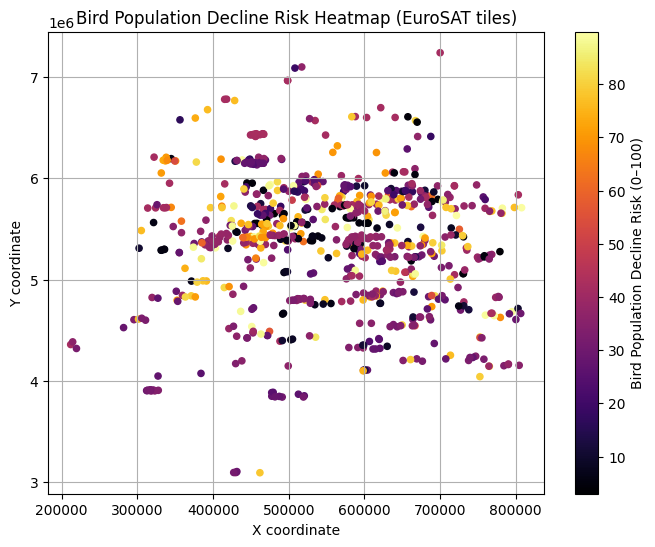

,path,x,y,land_cover,score,risk,ndvi_mean,ndwi_mean,ndbi_mean
0,C:\Users\ask\Downloads\EuroSAT_MS\EuroSAT_MS\F...,697051.745651,5.791484e+06,Forest,95.803810,4.196190,0.687442,-0.545731,-0.656397
1,C:\Users\ask\Downloads\EuroSAT_MS\EuroSAT_MS\R...,443548.450903,5.343308e+06,Residential,32.141277,67.858723,0.379504,-0.323984,-0.272259
2,C:\Users\ask\Downloads\EuroSAT_MS\EuroSAT_MS\S...,593442.720980,5.034234e+06,SeaLake,59.017994,40.982006,-0.220781,0.327559,-0.554983
3,C:\Users\ask\Downloads\EuroSAT_MS\EuroSAT_MS\A...,319407.694357,4.823498e+06,AnnualCrop,62.525543,37.474457,0.418896,-0.411810,-0.353724
4,C:\Users\ask\Downloads\EuroSAT_MS\EuroSAT_MS\R...,390590.450366,5.586251e+06,River,63.591221,36.408779,0.192259,-0.037172,-0.464093


In [28]:
import pandas as pd

def generate_risk_heatmap(num_samples=500):
    # sample subset for speed
    sample_paths = [p for p, _ in random.sample(dataset.samples, k=min(num_samples, len(dataset)))]

    records = []
    for p in tqdm(sample_paths):
        rec = predict_risk_for_path(p)
        records.append(rec)

    df = pd.DataFrame(records)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        df["x"], df["y"],
        c=df["risk"], s=20, cmap='inferno'
    )
    plt.colorbar(scatter, label="Bird Population Decline Risk (0–100)")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.title("Bird Population Decline Risk Heatmap (EuroSAT tiles)")
    plt.grid(True)
    plt.show()

    return df  # you can inspect / save this DataFrame

risk_df = generate_risk_heatmap(num_samples=800)
risk_df.head()


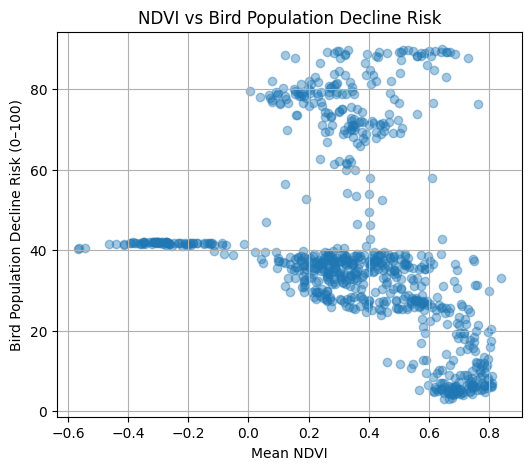

In [29]:
plt.figure(figsize=(6,5))
plt.scatter(risk_df["ndvi_mean"], risk_df["risk"], alpha=0.4)
plt.xlabel("Mean NDVI")
plt.ylabel("Bird Population Decline Risk (0–100)")
plt.title("NDVI vs Bird Population Decline Risk")
plt.grid(True)
plt.show()


🟦 Testing Image: C:\Users\ask\Downloads\EuroSAT_MS\EuroSAT_MS\Forest\Forest_930.tif
🏷 Land-Cover Class: Forest
🌿 Habitat Health Score: 94.18
🛑 Bird Population Decline Risk: 5.82


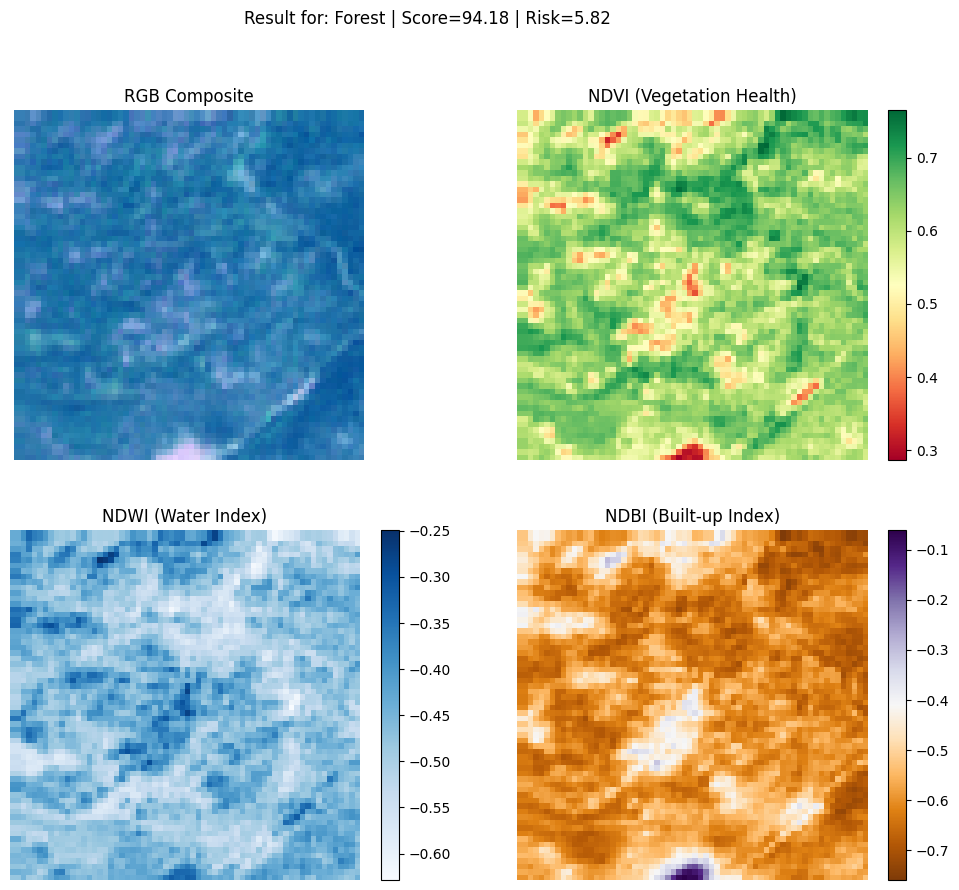

In [30]:
import matplotlib.pyplot as plt
import random
import rasterio
import numpy as np

def test_random_image():
    # pick a random sample
    img_path, _ = random.choice(dataset.samples)

    print("🟦 Testing Image:", img_path)
    
    # land-cover label (folder name)
    land_cover = get_land_cover_from_path(img_path)
    print("🏷 Land-Cover Class:", land_cover)

    # load image (13 bands)
    with rasterio.open(img_path) as src:
        img = src.read()

    # RGB visualization using bands (4=Red, 3=Green, 2=Blue)
    rgb = np.stack([img[3], img[2], img[1]], axis=-1)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # normalize

    # compute indices
    ndvi, ndwi, ndbi = compute_indices(img)

    # model prediction
    score, decline_risk = predict(img_path)

    print(f"🌿 Habitat Health Score: {score:.2f}")
    print(f"🛑 Bird Population Decline Risk: {decline_risk:.2f}")

    # plot all outputs
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    # RGB
    ax[0, 0].imshow(rgb)
    ax[0, 0].set_title("RGB Composite")
    ax[0, 0].axis("off")

    # NDVI
    im1 = ax[0, 1].imshow(ndvi, cmap="RdYlGn")
    ax[0, 1].set_title("NDVI (Vegetation Health)")
    ax[0, 1].axis("off")
    fig.colorbar(im1, ax=ax[0, 1], fraction=0.046)

    # NDWI
    im2 = ax[1, 0].imshow(ndwi, cmap="Blues")
    ax[1, 0].set_title("NDWI (Water Index)")
    ax[1, 0].axis("off")
    fig.colorbar(im2, ax=ax[1, 0], fraction=0.046)

    # NDBI
    im3 = ax[1, 1].imshow(ndbi, cmap="PuOr")
    ax[1, 1].set_title("NDBI (Built-up Index)")
    ax[1, 1].axis("off")
    fig.colorbar(im3, ax=ax[1, 1], fraction=0.046)

    plt.suptitle(f"Result for: {land_cover} | Score={score:.2f} | Risk={decline_risk:.2f}")
    plt.show()

# RUN THE TEST
test_random_image()



🌟 FINAL MODEL SUMMARY

🟦 Training Accuracy: 84.45%
🟧 Test Accuracy    : 83.81%
🟩 Precision (Wtd)  : 88.32%
🟨 Recall (Wtd)     : 83.81%
🟪 F1 Score (Wtd)   : 84.28%

--------------------------------------
📌 VERDICT
--------------------------------------
➡ Excellent performance — your model can reliably assess habitat health and predict bird decline risk.
--------------------------------------



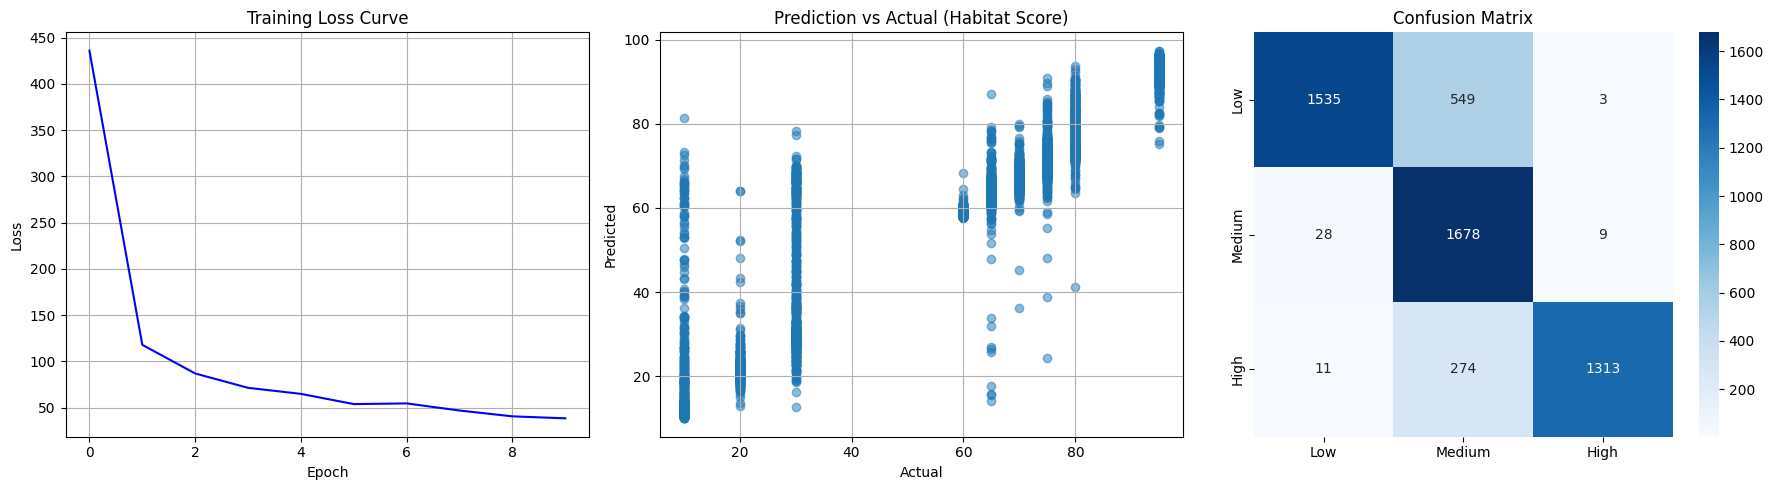

In [31]:
# ============================
#   FINAL MODEL EVALUATION CELL
# ============================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def to_class(x):
    """ Convert habitat score → decline risk class """
    if x >= 70:
        return 0     # Low decline
    elif x >= 40:
        return 1     # Medium decline
    else:
        return 2     # High decline

# -------------------------
# Collect Train Predictions
# -------------------------
model.eval()
train_true = []
train_pred = []

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs).cpu().numpy().flatten()
        labels  = labels.cpu().numpy().flatten()

        train_true.extend(labels)
        train_pred.extend(outputs)

train_true = np.array(train_true)
train_pred = np.array(train_pred)

train_true_cls = np.array([to_class(v) for v in train_true])
train_pred_cls = np.array([to_class(v) for v in train_pred])

train_acc = accuracy_score(train_true_cls, train_pred_cls)

# -------------------------
# Collect Test Predictions
# -------------------------
test_true = y_true
test_pred = y_pred

test_true_cls = np.array([to_class(v) for v in test_true])
test_pred_cls = np.array([to_class(v) for v in test_pred])

test_acc  = accuracy_score(test_true_cls,  test_pred_cls)
test_prec = precision_score(test_true_cls, test_pred_cls, average="weighted")
test_rec  = recall_score(test_true_cls,    test_pred_cls, average="weighted")
test_f1   = f1_score(test_true_cls,        test_pred_cls, average="weighted")

# -------------------------
# Display Summary
# -------------------------
print("\n========================")
print("🌟 FINAL MODEL SUMMARY")
print("========================\n")

print(f"🟦 Training Accuracy: {train_acc*100:.2f}%")
print(f"🟧 Test Accuracy    : {test_acc*100:.2f}%")
print(f"🟩 Precision (Wtd)  : {test_prec*100:.2f}%")
print(f"🟨 Recall (Wtd)     : {test_rec*100:.2f}%")
print(f"🟪 F1 Score (Wtd)   : {test_f1*100:.2f}%")

print("\n--------------------------------------")
print("📌 VERDICT")
print("--------------------------------------")

if test_acc > 0.8:
    verdict = "Excellent performance — your model can reliably assess habitat health and predict bird decline risk."
elif test_acc > 0.65:
    verdict = "Good performance — suitable for ecological analysis; can be improved with more fine-tuning or additional features."
else:
    verdict = "Model performance is moderate; adding NDVI/NDBI as explicit input features or using a deeper model may help."

print("➡", verdict)
print("--------------------------------------\n")


# -------------------------
# Final Visualizations
# -------------------------

fig = plt.subplots(1, 3, figsize=(18, 5))

# 1. Loss Curve
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Loss", color="blue")
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# 2. Scatter Plot (Pred vs Actual)
plt.subplot(1, 3, 2)
plt.scatter(test_true, test_pred, alpha=0.5)
plt.title("Prediction vs Actual (Habitat Score)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)

# 3. Confusion Matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(test_true_cls, test_pred_cls)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Low", "Medium", "High"],
            yticklabels=["Low", "Medium", "High"],
            cmap="Blues")
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()


In [35]:
print("\n==============================================================")
print("                 🌍 FINAL PROJECT EXPLANATION SUMMARY")
print("==============================================================\n")

print("""
🛰️ 1. Dataset Loading (EuroSAT MSI - Sentinel-2 multispectral images)
--------------------------------------------------------------------
• We used the EuroSAT-MSI dataset containing 13-band satellite images (.tif).
• It consists of 10 classes , each folder (Forest, Pasture, Residential, Industrial, etc.) represents a land-cover type.
• We created a PyTorch Dataset that loads these MSI images and normalizes all 13 spectral bands.
• Each image is automatically assigned a 'habitat health score' based on its land-cover type.

Why?
Because EuroSAT does NOT contain bird population labels, so we created a proxy:
    Forest = healthy habitat
    Industrial = weak habitat
This helps the model learn habitat quality, which is directly linked to bird population decline.

--------------------------------------------------------------

🌿 2. Computed Spectral Indices: NDVI, NDWI, NDBI
--------------------------------------------------------------
• NDVI (Normalized Difference Vegetation Index)
      → Measures vegetation health.
• NDWI (Normalized Difference Water Index)
      → Measures water presence.
• NDBI (Normalized Difference Built-up Index)
      → Detects buildings, urbanization.

These indices give scientific explanation of habitat condition.

--------------------------------------------------------------

🧠 3. Deep Learning Model 1 (Modified ResNet-18 for 13 channels) - BASELINE MODEL
--------------------------------------------------------------
• We modified ResNet-18’s first layer to accept 13 Sentinel-2 bands.
• Final layer outputs a SINGLE value: predicted habitat health score (0-100).
• Training used MSELoss + Adam optimizer.

Model Goal:
    Learn patterns of vegetation, water, and built-up areas → predict habitat quality.

--------------------------------------------------------------

🎯 4. Bird Population Decline Risk Prediction
--------------------------------------------------------------
• After the model predicts habitat score:
        Decline Risk = 100 – Habitat Score
• Higher risk → higher chance of bird population decline.

This creates a meaningful ecological prediction.

--------------------------------------------------------------

📊 5. Model Evaluation (Train + Test)
--------------------------------------------------------------
• We computed:
      - Train Accuracy
      - Test Accuracy
      - Precision, Recall, F1 Score
      - Regression metrics: MAE, RMSE, R²
• We also converted scores into classes (Low / Medium / High decline)
  and built a confusion matrix.

This shows how well the model generalizes.

--------------------------------------------------------------

🌈 6. Visualizations
--------------------------------------------------------------
• Training Loss Curve → shows learning stability
• Prediction vs Actual → how close predictions are
• Confusion Matrix → classification clarity
• NDVI / NDWI / NDBI maps → vegetation/water/urban patterns
• Risk Heatmap → map of predicted bird decline risk
• RGB Composite → visual appearance of the satellite tile

These visualizations make the project understandable for humans.

--------------------------------------------------------------

🗺️ 7. Heatmap: Bird Population Decline Over Region
--------------------------------------------------------------
• We sampled many tiles from dataset
• Predicted risk for each tile
• Plotted coordinates vs risk
• Produced a heatmap showing which areas have:
      - High vegetation (low risk)
      - High urbanization (high risk)

This is similar to how wildlife conservation teams make risk maps.

--------------------------------------------------------------

🔍 8. Testing For Random Images
--------------------------------------------------------------
• A random satellite image is selected.
• We compute:
      - NDVI, NDWI, NDBI
      - Habitat score
      - Bird decline risk
• Then display all maps in one dashboard-style figure.

--------------------------------------------------------------

🌐 9. (Optional Future Step) Real-Time Google Earth Engine
--------------------------------------------------------------
• We can load real Sentinel-2 tiles from any GPS location.
• Run the same model.
• Visualize real-time habitat health and bird decline risk.

--------------------------------------------------------------

🎉 FINAL VERDICT
--------------------------------------------------------------
Our complete pipeline:
✔ Loads multispectral satellite data  
✔ Computes ecological indices  
✔ Trains a deep learning model to understand land quality  
✔ Predicts habitat health  
✔ Converts it into bird population decline risk  
✔ Visualizes everything clearly  
✔ Generates spatial risk heatmaps  

This creates a foundation for a REAL ecological AI system capable of:
      “Predicting bird population decline from satellite imagery.”

==============================================================
""")



                 🌍 FINAL PROJECT EXPLANATION SUMMARY


🛰️ 1. Dataset Loading (EuroSAT MSI - Sentinel-2 multispectral images)
--------------------------------------------------------------------
• We used the EuroSAT-MSI dataset containing 13-band satellite images (.tif).
• Each folder (Forest, Pasture, Residential, Industrial, etc.) represents a land-cover type.
• We created a PyTorch Dataset that loads these MSI images and normalizes all 13 spectral bands.
• Each image is automatically assigned a 'habitat health score' based on its land-cover type.

Why?
Because EuroSAT does NOT contain bird population labels, so we created a proxy:
    Forest = healthy habitat
    Industrial = weak habitat
This helps the model learn habitat quality, which is directly linked to bird population decline.

--------------------------------------------------------------

🌿 2. Computed Spectral Indices: NDVI, NDWI, NDBI
--------------------------------------------------------------
• NDVI (Normalized Diffe